<a href="https://colab.research.google.com/github/ShreyasKulkarni26/krittika-python-assignment/blob/main/Portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from scipy.optimize import minimize
import numpy as np

In [ ]:
tickers = ['SPY','BND','GLD','QQQ']
end_date = datetime.today()
start_date = end_date - timedelta(days = 10*365)
print(start_date)

2013-10-02 15:20:29.189283


In [ ]:
df = pd.DataFrame()

In [ ]:
for ticker in tickers:
  data=yf.download(ticker, start = start_date, end = end_date)
  df[ticker]=data['Adj Close']
print(df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
                   SPY        BND         GLD         QQQ
Date                                                     
2013-10-02  141.008347  62.056065  127.059998   72.983177
2013-10-03  139.708099  62.086807  127.180000   72.131012
2013-10-04  140.766693  62.017635  126.529999   72.754112
2013-10-07  139.549774  62.063747  127.639999   72.149345
2013-10-08  137.924500  62.040661  127.400002   70.756569
...                ...        ...         ...         ...
2023-09-25  432.230011  69.949997  177.699997  359.609985
2023-09-26  425.880005  69.879997  176.279999  354.209991
2023-09-27  426.049988  69.629997  174.100006  355.040009
2023-09-28  428.519989  69.809998  173.229996  358.010010
2023-09-29  427.480011  69.7

In [ ]:
log_returns = np.log(df/df.shift(1))
log_returns = log_returns.dropna()
print(log_returns)

                 SPY       BND       GLD       QQQ
Date                                              
2013-10-03 -0.009264  0.000495  0.000944 -0.011745
2013-10-04  0.007549 -0.001115 -0.005124  0.008601
2013-10-07 -0.008683  0.000743  0.008734 -0.008347
2013-10-08 -0.011715 -0.000372 -0.001882 -0.019493
2013-10-09  0.000725 -0.000619 -0.010177 -0.003113
...              ...       ...       ...       ...
2023-09-25  0.004196 -0.007406 -0.005164  0.004739
2023-09-26 -0.014800 -0.001001 -0.008023 -0.015130
2023-09-27  0.000399 -0.003584 -0.012444  0.002341
2023-09-28  0.005781  0.002582 -0.005010  0.008330
2023-09-29 -0.002430 -0.000430 -0.010329  0.000726

[2515 rows x 4 columns]


In [ ]:
cov_matrix = log_returns.cov()*252
#252 to annualise the value
print(cov_matrix)

          SPY       BND       GLD       QQQ
SPY  0.030835  0.000755  0.000410  0.035070
BND  0.000755  0.002605  0.002636  0.001062
GLD  0.000410  0.002636  0.020120  0.000916
QQQ  0.035070  0.001062  0.000916  0.046260


Now the standard deviation of the portfolio which gives us the combined liquidity/risk of the entire portfolio

In [ ]:
def standard_dev(weights,cov_matrix):
  variance = weights.T @ cov_matrix @ weights
  return(np.sqrt(variance))

Calculate the expected returns from the past returns

In [ ]:
def expected_return(weights,log_returns):
  return np.sum(log_returns.mean()*weights)*252

Find the Sharpe Ratio -> (Portfolio Return - Risk Free Rate) / (Standard deviation)

In [ ]:
def sharpe(weights, log_returns, cov_matrix,risk_free_rate):
  return((expected_return(weights, log_returns)-risk_free_rate)/standard_dev(weights, cov_matrix))

In [ ]:
risk_free_rate=0.0459 #from the fed

In [ ]:
def neg_sharpe(weights, log_returns, cov_matrix,risk_free_rate):
  return -sharpe(weights, log_returns, cov_matrix,risk_free_rate)
constraints = {'type':'eq','fun':lambda weights: np.sum(weights) - 1}
bounds = [(0,0.5) for _ in range(len(tickers))]

In [ ]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.25 0.25 0.25 0.25]


In [ ]:
optimized_results = minimize(neg_sharpe, initial_weights, args = (log_returns, cov_matrix, risk_free_rate), method = 'SLSQP',constraints = constraints, bounds = bounds)


In [ ]:
optimal_weights = optimized_results.x

In [ ]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_dev(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.5000
BND: 0.0000
GLD: 0.0000
QQQ: 0.5000
Expected Annual Return: 0.1353
Expected Volatility: 0.1919
Sharpe Ratio: 0.4658


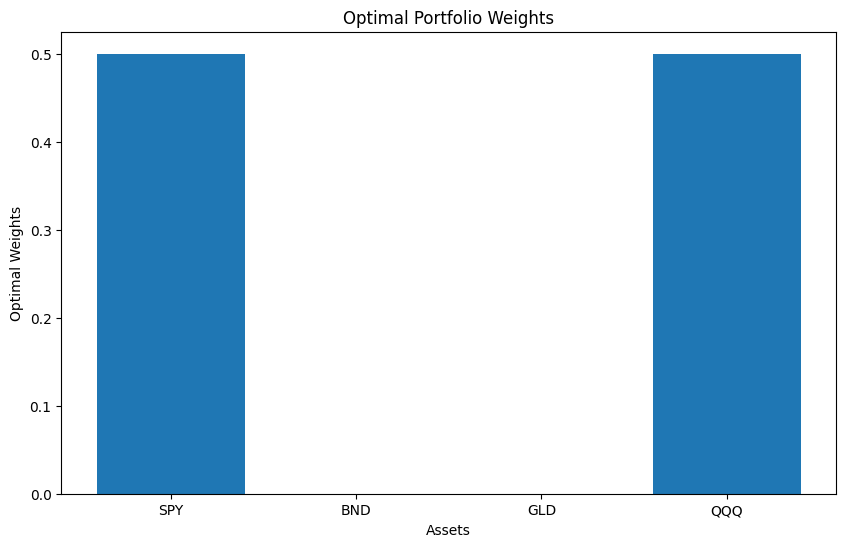

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()